## Random forest classification

### Imports and global variables

In [569]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display
from sklearn.metrics import roc_curve, auc

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

plt.style.use('fivethirtyeight')
%matplotlib inline

path = '/Users/katbishop/Desktop/DSI-SF2-bishopkd/projects/capstone/data/'

#### Load the data

In [570]:
# load training data
df = pd.read_csv(path + 'df.csv')
del df['Unnamed: 0']
#del df['Unnamed: 0.1']

# load held-out testing data
df_test = pd.read_csv(path + 'df_test.csv')
del df_test['Unnamed: 0']

df_all = pd.concat([df,df_test], axis=0).reset_index()
del df_all['index']

print df.shape
print df_test.shape
print df_all.shape
df_all.head(2)

(780, 63)
(141, 63)
(921, 63)


,adj,adj_compare,adj_sup,adv,adv_compare,adv_part,adv_sup,avg_sent_len,avg_word_len,best_seller,...,verb_count,verb_ger,verb_past,verb_pp,verb_sing_pres,wh_adv,wh_determ,wh_poss,wh_pronoun,word_count
0,0.065870,0.001992,0.003091,0.063397,0.001099,0.006937,0.000206,13,4,1,...,2599.0,0.023079,0.066282,0.021087,0.025483,0.006319,0.003915,0.0,0.003846,14559
1,0.064633,0.003045,0.001282,0.064847,0.001709,0.008333,0.000374,18,4,1,...,3359.0,0.022221,0.070135,0.024838,0.019497,0.005769,0.004754,0.0,0.006303,18721


In [571]:
# subset the data
sf = df_all[df_all['sci_fi']==1]
rm = df_all[df_all['sci_fi']==0]
print sf.shape
print rm.shape

(470, 63)
(451, 63)


In [572]:
rm.best_seller.mean()

0.49002217294900224

#### Science-fiction

In [846]:
y_sf = sf['best_seller']
X_sf = sf[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']]

print y_sf_all.shape, X_sf_all.shape

(470,) (470, 54)


In [574]:
X_sf, X_sf_test, y_sf, y_sf_test = train_test_split(X_sf, y_sf, test_size=0.3)

print X_sf.shape, y_sf.shape
print X_sf_test.shape, y_sf_test.shape

(329, 54) (329,)
(141, 54) (141,)


#### Random Forest Classifier

In [624]:
rfc = RandomForestClassifier()
rf_params = {
    'max_features':['log2','sqrt', 2,3,4,5],
    'max_depth':[2,3,4, None],
    #'min_samples_leaf':np.linspace(1,30,20),
    'n_estimators':[1000]
}

rf_gs_sf = GridSearchCV(rfc, rf_params, cv=5, verbose=1, n_jobs=-1)
rf_model_sf = rf_gs_sf.fit(X_sf, y_sf) 

rf_proba_sf = rf_model_sf.predict_log_proba(X_sf_test)
y_sf_pp = rf_model_sf.predict_log_proba(X_sf_test)[:,1]

rfc_best_sf = rf_gs_sf.best_estimator_
print "best estimator", rfc_best_sf
print 
print "best parameters",  rf_gs_sf.best_params_
print 
print "best score", rf_gs_sf.best_score_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.8min finished


best estimator RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

best parameters {'max_features': 5, 'n_estimators': 1000, 'max_depth': None}

best score 0.942249240122


In [635]:
print "score on testing data", rfc_best_sf.score(X_sf_test, y_sf_test)

score on testing data 0.950354609929


In [733]:
## Print Feature importances
feature_importance_sf = pd.DataFrame({ 'feature':X_sf.columns, 
                                   'importance':rfc_best_sf.feature_importances_
                                  })

feature_importance_sf.sort_values('importance', ascending=False, inplace=True)
feature_importance_sf.head(10)

,feature,importance
20,poss_ending,0.088046
2,lex_diversity,0.062716
22,pronoun_poss,0.052336
16,noun_prop,0.046092
27,inf_to,0.037255
7,determiner,0.033713
14,verb_aux,0.033416
50,verb.possession,0.027008
30,verb_past,0.026765
47,verb.emotion,0.025299


In [734]:
feature_importance_sf.tail(2)

,feature,importance
5,profane,0.002020
1,avg_word_len,0.000118


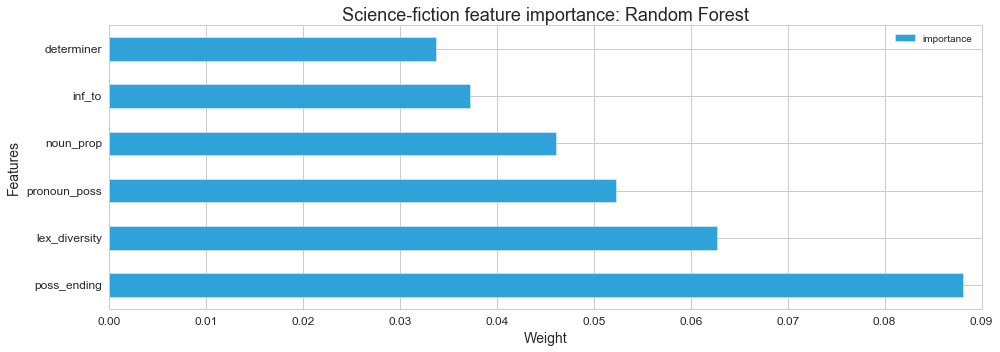

In [628]:
feat = feature_importance_sf.set_index('feature')
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
bar_width = 0.35
feat.sort_values('importance', ascending=0).head(6).plot(kind='barh', figsize=(14,5),fontsize=12)
plt.xlabel('Weight',fontsize=14)
plt.ylabel('Features',fontsize=14)
plt.title('Science-fiction feature importance: Random Forest',fontsize=18)
plt.tight_layout()
plt.show()

In [629]:
y_sf_pred_rfc= rfc_best.predict(X_sf_test)

print y_sf_pred_rfc.shape, y_sf_test.shape

cls_rep = classification_report(y_sf_test, y_sf_pred_rfc)
print cls_rep 

(141,) (141,)
             precision    recall  f1-score   support

          0       0.66      0.94      0.78        67
          1       0.91      0.57      0.70        74

avg / total       0.79      0.74      0.74       141



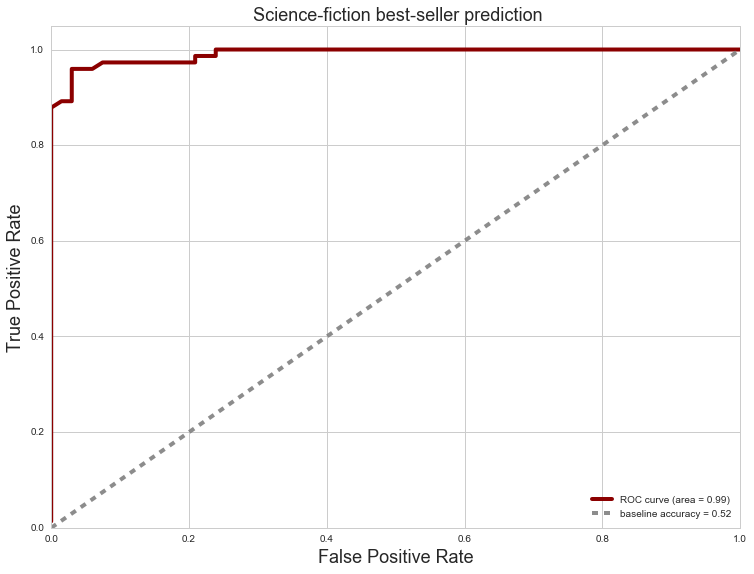

In [630]:
plot_roc_curve(target=y_sf_test, predict_proba=rf_proba_sf[:,1], title='Science-fiction best-seller prediction')

#### Romance

In [631]:
y_rm = rm['best_seller']
X_rm = rm[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']]


print y_rm.shape, X_rm.shape

(451,) (451, 54)


In [632]:
X_rm, X_rm_test, y_rm, y_rm_test = train_test_split(X_rm, y_rm, test_size=0.3)

print X_rm.shape, y_rm.shape
print X_rm_test.shape, y_rm_test.shape

(315, 54) (315,)
(136, 54) (136,)


In [633]:
rfc = RandomForestClassifier()
# rf_params = {
#     'max_features':['log2','sqrt', 2,3,4,5],
#     'max_depth':[1,2,3,4],
#     'min_samples_leaf':np.linspace(1,20,10),
#     'n_estimators':[100]
# }
rf_params = {
    'max_features':['log2','sqrt'],
    'max_depth':[5,6,7,8,9,None],
    'n_estimators':[1000]
}

rf_gs_rm = GridSearchCV(rfc, rf_params, cv=5, verbose=1, n_jobs=-1)
rf_model_rm = rf_gs_rm.fit(X_rm, y_rm) 

rf_proba_rm = rf_model_rm.predict_log_proba(X_rm_test)

rfc_best_rm = rf_gs_rm.best_estimator_

print "best estimator", rfc_best_rm
print 
print "best parameters",  rf_gs_rm.best_params_
print 
print "best score", rf_gs_rm.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.5min finished


best estimator RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

best parameters {'max_features': 'log2', 'n_estimators': 1000, 'max_depth': None}

best score 0.926984126984


In [636]:
print "score on testing data", rfc_best_rm.score(X_rm_test, y_rm_test)

score on testing data 0.933823529412


In [735]:
## Print Feature importances
feature_importance_rm = pd.DataFrame({ 'feature':X_rm.columns, 
                                   'importance':rfc_best_rm.feature_importances_
                                  })

feature_importance_rm.sort_values('importance', ascending=False, inplace=True)
feature_importance_rm.head(10)

,feature,importance
2,lex_diversity,0.070802
30,verb_past,0.041514
26,adv_part,0.038070
25,adv_sup,0.034204
31,verb_ger,0.031437
6,conj_coord,0.027474
17,noun_prop_pural,0.026662
50,verb.possession,0.025712
22,pronoun_poss,0.024990
49,verb.perception,0.020447


In [737]:
feature_importance_rm.tail(2)

,feature,importance
1,avg_word_len,0.009012
0,avg_sent_len,0.008769


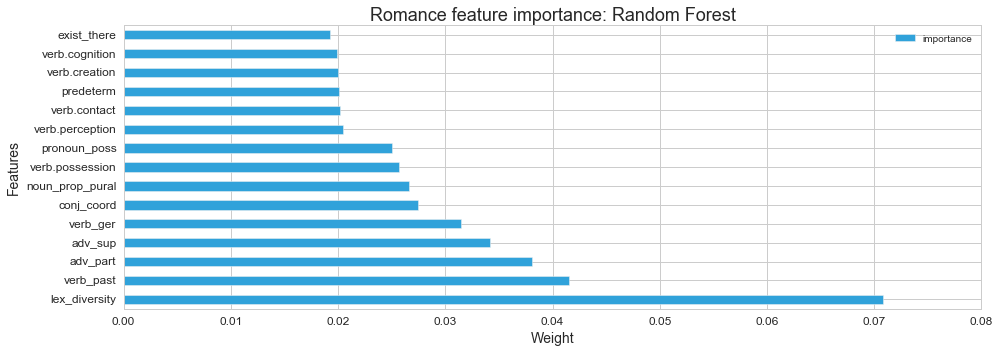

In [736]:
feat_rm = feature_importance_rm.set_index('feature')
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
bar_width = 0.35
feat_rm.sort_values('importance', ascending=0).head(15).plot(kind='barh', figsize=(14,5),fontsize=12)
plt.xlabel('Weight',fontsize=14)
plt.ylabel('Features',fontsize=14)
plt.title('Romance feature importance: Random Forest',fontsize=18)
plt.tight_layout()
plt.show()

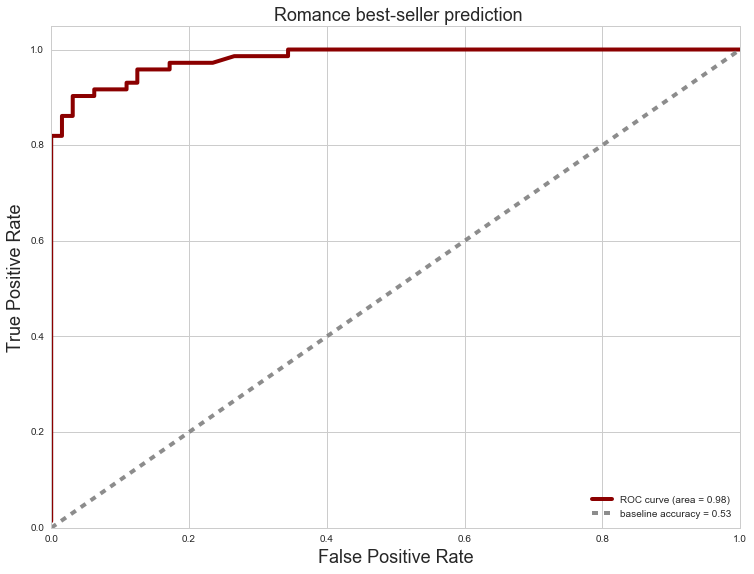

In [640]:
plot_roc_curve(target=y_rm_test, predict_proba=rf_proba_rm[:,1], title='Romance best-seller prediction')

## Best-seller predictor

In [603]:
def predict_8ball(mod, X_test, title):
    df = pd.DataFrame(['best_seller','probability','title'])
    i=0
    y_other_pred = mod.predict(X_test)
    proba_other = mod.predict_proba(X_test)
    for y, p, t in zip(y_other_pred, proba_other, title):
        if y==1:
            df.ix[i,'best_seller'] = 'best seller'
            df.ix[i,'probability'] = p[1]
        else:
            df.ix[i,'best_seller'] = 'flop'
            df.ix[i,'probability'] = p[0]
        df.ix[i,'title'] = t
        i+=1
    del df[0]
    return df.sort_values(['best_seller','probability'],ascending=[True,False])


In [816]:
df_other = pd.read_csv(path + 'df_other.csv')
del df_other['Unnamed: 0']

y_other = df_other['best_seller']
X_other = df_other[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']]


In [818]:
predict_8ball(rf_model_rm, X_other.ix[0,:],df_other['title']).head(1)

/Users/katbishop/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/katbishop/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


,best_seller,probability,title
0,best seller,0.773,a plate of wheat for three sad tigers - ja


In [651]:
print sf.shape

y_all = sf['best_seller']
X_all = sf[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']]

results_sf = predict_8ball(rf_model_sf, X_all, sf['title'])


(470, 63)


In [652]:
results_sf.head(5)

,best_seller,probability,title
127,best seller,0.987,rainbows end - vernor vinge7
42,best seller,0.986,consider phlebas - iain m banks2
13,best seller,0.985,a fire upon the deep - vernor vinge3
15,best seller,0.984,a fire upon the deep - vernor vinge5
17,best seller,0.984,a fire upon the deep - vernor vinge7


In [653]:
results_sf[(results_sf['best_seller']=='flop')].head(5)

,best_seller,probability,title
343,flop,0.972,the best of all possible worlds - karen lord3
224,flop,0.971,binary - stephanie saulter4
287,flop,0.971,rising tide - rajan khanna7
465,flop,0.969,zero - adam moon5
281,flop,0.966,rising tide - rajan khanna10


In [654]:
y_all = rm['best_seller']
X_all = rm[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']]

results_rm = predict_8ball(rf_model_rm, X_all, rm['title'])


In [655]:
results_rm.head(5)

,best_seller,probability,title
418,best seller,0.963,see me - nicholas sparks7
122,best seller,0.958,outlander - diana gabaldon2
129,best seller,0.957,outlander - diana gabaldon9
126,best seller,0.955,outlander - diana gabaldon6
85,best seller,0.953,grey - e l james5


In [656]:
results_rm[(results_rm['best_seller']=='flop')].head(5)

,best_seller,probability,title
302,flop,0.967,rex - clementine elin2
307,flop,0.964,rex - clementine elin7
308,flop,0.961,rex - clementine elin8
372,flop,0.958,the last dance - cf sheeler2
379,flop,0.954,the last dance - cf sheeler9


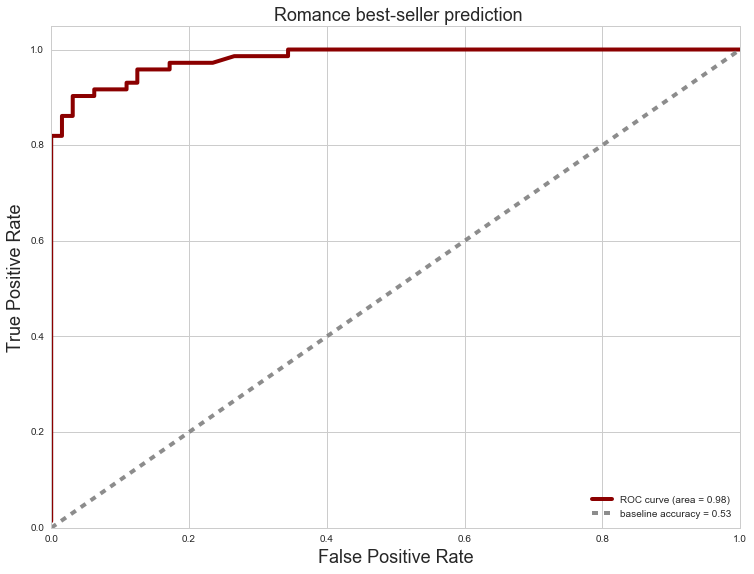

In [657]:
plot_roc_curve(target=y_rm_test, predict_proba=rf_proba_rm[:,1], title='Romance best-seller prediction')

In [558]:
def plot_roc_curve(target=False, predict_proba=False, title='Your prediction'):

    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    FPR[1], TPR[1], _ = roc_curve(target,predict_proba)
    ROC_AUC[1] = auc(FPR[1], TPR[1])
    acc_ = np.abs(0.5 - np.mean(target)) + 0.5

    plt.figure(figsize=[11,9])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4, color='darkred')
    #plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=4, label='baseline accuracy = %0.2f' % acc_)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title(' %s' % title, fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

#### Variable manipulation

In [560]:
df_mean = pd.DataFrame(X_all.mean()).T
df_mean

,avg_sent_len,avg_word_len,lex_diversity,polarity,subjectivity,profane,conj_coord,determiner,exist_there,foreign_word,...,verb.consumption,verb.contact,verb.creation,verb.emotion,verb.motion,verb.perception,verb.possession,verb.social,verb.stative,verb.weather
0,9.755556,3.822222,0.108423,0.075647,0.48345,9.669269e-08,0.034642,0.081625,0.001419,0.000093,...,0.009271,0.098698,0.007002,0.0437,0.132105,0.060374,0.101073,0.09726,0.186955,0.001025


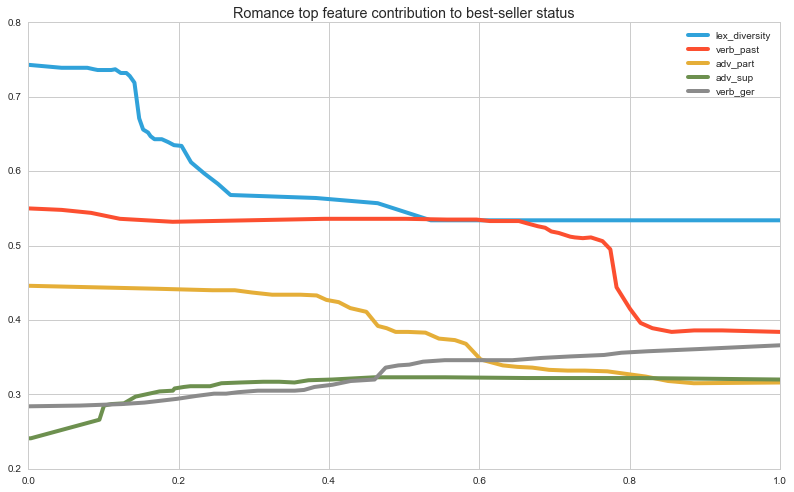

In [788]:
vp_dict={}
percentiles = range(2,100,3)

#SCI-FI
# X = X_sf
# model = rfc_best_sf
# var_names = feature_importance_sf['feature'].head(5).tolist()
# title = 'Science-fiction top feature contribution to best-seller status'

#ROMANCE
X = X_rm
model = rfc_best_rm
var_names = feature_importance_rm['feature'].head(5).tolist()
title = 'Romance top feature contribution to best-seller status'

for i, name in enumerate(var_names):
    vp_dict[i] = np.percentile(X[name].values, percentiles)

pp_matrix = np.zeros((33,33))

avg_row = pd.DataFrame(X.mean(axis=0)).T

fig = plt.figure(figsize=(12,8))

graph=pd.DataFrame({'value':0 ,'probability': 0},index=[0])

for vals, name in zip(vp_dict.values(),var_names):
    for row, s in enumerate(vals):
        avg_row.loc[:,name] = s
        pred_prob = model.predict_proba(avg_row.values)[:,1]
        graph.append([s,pred_prob[0]])
        pp_matrix[row, col] = pred_prob
        graph.ix[row,'value'] = s
        graph.ix[row,'probability'] = pred_prob[0]
        
    graph['norm'] = (graph['value'] - graph['value'].min()) / (graph['value'].max() - graph['value'].min())
    plt.plot(graph['norm'],graph['probability'], label=name)
plt.title(title)    
plt.legend()
plt.show()

In [819]:
# SCI-FI
which = 'Science-fiction'
# X = X_sf
# model = rfc_best_sf
# var_names = feature_importance_sf['feature'].head(2).tolist()

# ROMANCE
which = 'Romance'
X = X_rm
model = rfc_best_rm
var_names = feature_importance_rm['feature'].head()[0:2].tolist()
print var_names

percentiles = range(5,100,5)
for i, name in enumerate(var_names):
    vp_dict[i] = np.percentile(X[name].values, percentiles)

pp_matrix = np.zeros((19,19))

avg_row = pd.DataFrame(X.mean(axis=0)).T

for row, s in enumerate(vp_dict.values()[0]):
    for col, p in enumerate(vp_dict.values()[1]):
        avg_row.loc[:,var1] = s
        avg_row.loc[:,var2] = p
        pred_prob = model.predict_proba(avg_row.values)[:,1]
        pp_matrix[row, col] = pred_prob



['lex_diversity', 'verb_past']


Change in Romance best-seller probabilty with the increase of lex_diversity and verb_past
Actually what is this saying?


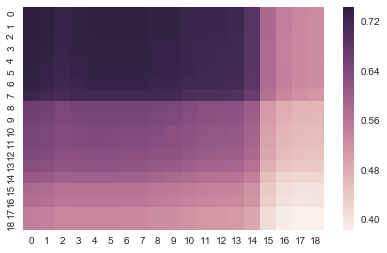

In [808]:
sns.heatmap(pd.DataFrame(pp_matrix))
print 'Change in',which, 'best-seller probabilty with the increase of',var_names[0],'and',var_names[1]
print 'Actually what is this saying?'